In [1]:
import numpy as np
from scipy import fft
from scipy.sparse import csr_matrix
from scipy.io.wavfile import read
from librosa.core import note_to_hz
import matplotlib.pyplot as plt
from scipy.signal import get_window
import scipy
import filters
import warnings

import torch
import torch.nn as nn
from torch.nn.functional import conv1d
from librosa import stft

# parameters
# nargin = 6
bins = 24 # bins per octave
fs = 22050 # sampling rate

# fmax = 61.73541266 # same as 1 octave
fmax = 880
fmin = note_to_hz('A3')
thresh= 0.0054

stride = 512

s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*450*s, dtype=np.float32) + np.sin(2*np.pi*500*s, dtype=np.float32) +np.sin(2*np.pi*600*s, dtype=np.float32) 

def nextpow2(A):
    return int(np.ceil(np.log2(A)))

def create_cqt_kernals(fs, fmin, fmax=None, n_bins=84, bins_per_octave=12, window='hann'):
    Q = 1/(2**(1/bins_per_octave)-1)
    fftLen = 2**nextpow2(np.ceil(Q * fs / fmin))
    # minWin = 2**nextpow2(np.ceil(Q * fs / fmax))
    if (fmax != None) and  (n_bins == None):
        n_bins = np.ceil(bins_per_octave * np.log2(fmax / fmin)) # Calculate the number of bins
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))    
    elif (fmax == None) and  (n_bins != None):
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
    else:
        warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
        n_bins = np.ceil(bins_per_octave * np.log2(fmax / fmin)) # Calculate the number of bins
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))

    tempKernel = np.zeros((int(n_bins), int(fftLen)), dtype=np.complex64)
    specKernel = np.zeros((int(n_bins), int(fftLen)), dtype=np.complex64)    
    for k in range(0, int(n_bins)):
        freq = freqs[k]
        l = np.ceil(Q * fs / freq)
        if l%2==1: # pad more zeros on RHS
            start = int(np.ceil(fftLen / 2.0 - l / 2.0))-1
        else:
            start = int(np.ceil(fftLen / 2.0 - l / 2.0))
        tempKernel[k, start:start + int(l)] = get_window(window,int(l), fftbins=True)*np.exp(np.r_[-l//2:l//2]*1j*2*np.pi*freq/fs)/l
        # specKernel[k, :]=fft(conj(tempKernel[k, :]))
        specKernel[k, :] = fft(tempKernel[k])
        
    return specKernel[:,:fftLen//2+1], fftLen

In [2]:
def complex_mul(cqt_filter, stft):
    cqt_filter_real = cqt_filter[0]
    cqt_filter_imag = cqt_filter[1]
    fourier_real = stft[0]
    fourier_imag = stft[1]
    
    CQT_real = torch.matmul(cqt_filter_real, fourier_real) - torch.matmul(cqt_filter_imag, fourier_imag)
    CQT_imag = torch.matmul(cqt_filter_real, fourier_imag) + torch.matmul(cqt_filter_imag, fourier_real)   
    
    return CQT_real, CQT_imag

In [3]:
from librosa.core import cqt

In [4]:
class CQT_class(torch.nn.Module):
    def __init__(self, sr=22050, hop_length=512, fmin=220, fmax=None, n_bins=84, bins_per_octave=12, window='hann', center=False, pad_mode='reflect'):
        super(CQT_class, self).__init__()
        #To Do center = False#
        
        self.hop_length = hop_length
        self.center = center
        self.pad_mode = pad_mode
        
        # creating kernals for CQT
        self.cqt_kernals, self.kernal_width = create_cqt_kernals(sr, fmin, fmax, n_bins, bins_per_octave, window)
        self.cqt_kernals_real = torch.tensor(self.cqt_kernals.real)
        self.cqt_kernals_imag = torch.tensor(self.cqt_kernals.imag)
        
        # creating kernals for stft
        wsin, wcos = filters.create_fourier_kernals(self.kernal_width, windowing="no", freq_scale='no')
        self.wsin = torch.tensor(wsin)
        self.wcos = torch.tensor(wcos)        
        
    def forward(self,x):
        x = x[None, None, :]
        if self.center:
            if self.pad_mode == 'constant':
                padding = nn.ConstantPad1d(self.kernal_width//2, 0)
            elif self.pad_mode == 'reflect':
                padding = nn.ReflectionPad1d(self.kernal_width//2)
            print(x.shape)
            x = padding(x)
            print(x.shape)
        # STFT
        fourier_real = conv1d(x, self.wcos, stride=self.hop_length)
        fourier_imag = conv1d(x, self.wsin, stride=self.hop_length)
        
        # CQT
        CQT_real, CQT_imag = complex_mul((self.cqt_kernals_real, self.cqt_kernals_imag), 
                                         (fourier_real, fourier_imag))
        
        # Getting CQT Amplitude
        CQT = torch.sqrt(CQT_real.pow(2)+CQT_imag.pow(2))
        
        return CQT

In [5]:
CQT_layer = CQT_class(fs, stride, fmin, fmax=None, n_bins=48, bins_per_octave=bins, center=True, pad_mode='constant')

torch.Size([1, 1, 220500])
torch.Size([1, 1, 224596])


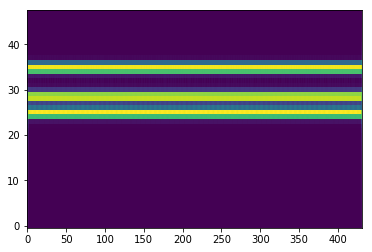

In [6]:
plt.imshow(CQT_layer(torch.tensor(x))[0],aspect='auto', origin='lower')

# GPU implmentation

In [7]:
# CQT_real, CQT_imag = complex_mul((cqt_filter_real, cqt_filter_imag), (fourier_real, fourier_imag))

# CQT_GPU = torch.sqrt(CQT_real.pow(2)+CQT_imag.pow(2))

# plt.imshow(CQT_GPU[0],aspect='auto', origin='lower')

# CPU implementation

In [8]:
kernal_width = CQT_layer.kernal_width
cqt_filter = CQT_layer.cqt_kernals

In [9]:
x_fft = stft(x, CQT_layer.kernal_width, hop_length=512, window='ones', center=True, pad_mode='constant')

In [10]:
CQT = np.dot(cqt_filter, x_fft)

torch.Size([1, 1, 220500])
torch.Size([1, 1, 224596])


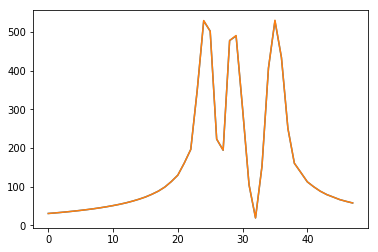

In [11]:
plt.plot(CQT_layer(torch.tensor(x))[0][:,0].numpy())
plt.plot(abs(CQT)[:,0])

torch.Size([1, 1, 220500])
torch.Size([1, 1, 224596])


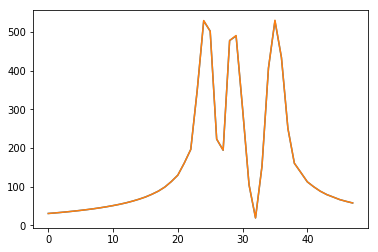

In [12]:
plt.plot(CQT_layer(torch.tensor(x))[0][:,0].numpy())
plt.plot(abs(CQT)[:,0])

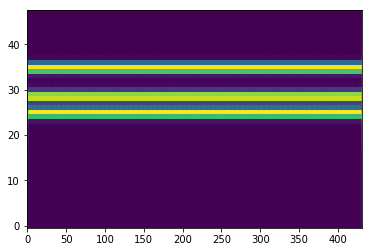

In [13]:
plt.imshow(abs(CQT),aspect='auto', origin='lower')

In [14]:
abs(CQT)[3][236]

0.0016228516

In [15]:

plt.plot(CQT_GPU[0][3].numpy()[210:230])
plt.plot(abs(CQT)[3][210:230])
plt.ylabel('Amplitude')
plt.xlabel('Freq bins')
plt.legend(['Python', 'Pytorch'])
plt.title('Python CPU CQT vs Pytorch CQT')

NameError: name 'CQT_GPU' is not defined

In [ ]:
np.allclose(fourier_real[0], x_fft.real, 1)

In [ ]:
plt.plot(fourier_real[0][0].numpy())
plt.plot(x_fft.real[0])

In [ ]:
counter = 0
for i in range(len(x_fft.real)):
    a = np.allclose(fourier_real[0][i].numpy(),x_fft.real[i], 1e-4)
    if a==True:
        counter+=1
    print(a)
print("number of True = ", counter)

In [ ]:
for i in range(len(abs(CQT))):
    a = np.allclose(CQT_GPU[0][i], abs(CQT)[i],1)
    print(a)

In [ ]:
plt.plot(CQT.real[1][50:100])
plt.plot(CQT_real[0][1][50:100].numpy())

In [ ]:
CQT.real[1]

In [ ]:
manual_CQT = np.dot(cqt_filter.real, x_fft.real) - np.dot(cqt_filter.imag, x_fft.imag)

In [ ]:
manual_CQT[0]

In [ ]:
CQT_real[0][1]

In [ ]:
x_fft.shape

In [ ]:
import numpy as np

In [ ]:
a_shape = (3,10)
b_shape = (10,3)

# Generating the first complex matrix a
np.random.seed(0)
a_real = np.random.randn(a_shape[0], a_shape[1])
np.random.seed(1)
a_imag = np.random.randn(a_shape[0], a_shape[1])
a = a_real + a_imag*1j

# Generating the second complex matrix b
np.random.seed(2)
b_real = np.random.randn(b_shape[0], b_shape[1])
np.random.seed(3)
b_imag = np.random.randn(b_shape[0], b_shape[1])
b = b_real + b_imag*1j

# 1st approach to do complex multiplication
output1 = np.dot(a,b)
# Manaul complex multiplication
output_real = np.dot(a.real,b.real) - np.dot(a.imag,b.imag)

In [ ]:
np.array_equal(output1.real, output_real) # the results are the same

In [ ]:
a_shape = (280,4000)
b_shape = (4000,400)

# Generating the first complex matrix a
np.random.seed(0)
a_real = np.random.randn(a_shape[0], a_shape[1])
np.random.seed(1)
a_imag = np.random.randn(a_shape[0], a_shape[1])
a = a_real + a_imag*1j

# Generating the second complex matrix b
np.random.seed(2)
b_real = np.random.randn(b_shape[0], b_shape[1])
np.random.seed(3)
b_imag = np.random.randn(b_shape[0], b_shape[1])
b = b_real + b_imag*1j

# 1st approach to do complex multiplication
output1 = np.dot(a,b)
# 2nd approach to do complex multiplication
output_real = np.matmul(a.real,b.real) - np.matmul(a.imag,b.imag)

In [ ]:
np.allclose(output1.real, output_real)

In [ ]:
import torch

In [ ]:
a_torch_real = torch.tensor(a.real)
a_torch_imag = torch.tensor(a.imag)

b_torch_real = torch.tensor(b.real)
b_torch_imag = torch.tensor(b.imag)

In [ ]:
output_torch_real = torch.matmul(a_torch_real,b_torch_real) - torch.matmul(a_torch_imag, b_torch_imag)

In [ ]:
np.allclose(output_torch_real, output_real)

In [ ]:
np.allclose(output_torch_real, output1.real)